# Self-Driving Car Engineer Nanodegree
## Project: **Advanced Lane Finding**

### Import Packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline


### Tracking Class

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  

left_line = Line()
right_line = Line()


## Camera Calibration

### Distortion correction

In [3]:
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


### Calibration

camera_cal/calibration1.jpg : false
camera_cal/calibration4.jpg : false
camera_cal/calibration5.jpg : false


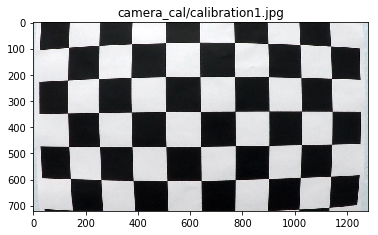

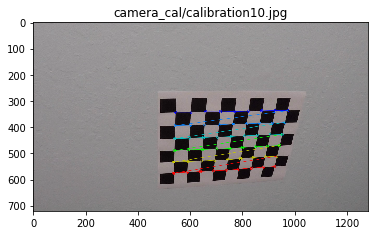

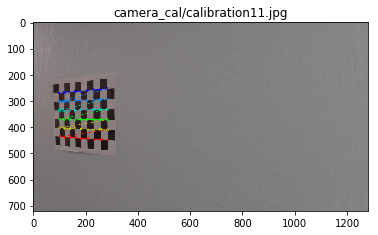

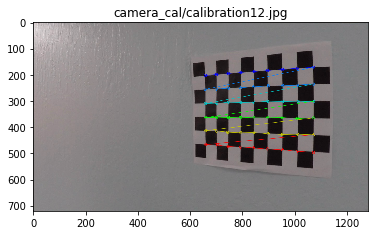

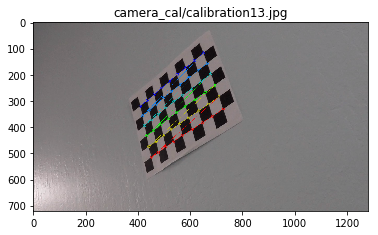

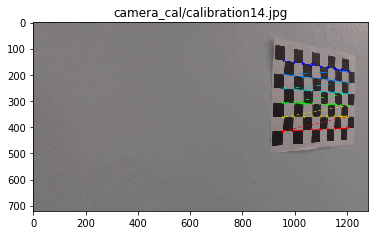

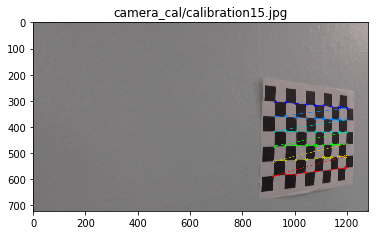

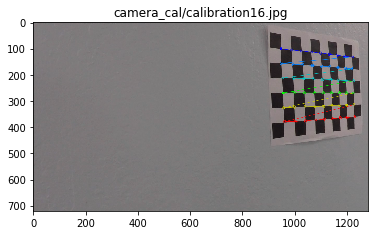

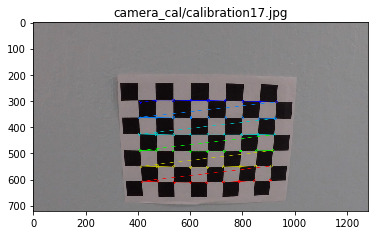

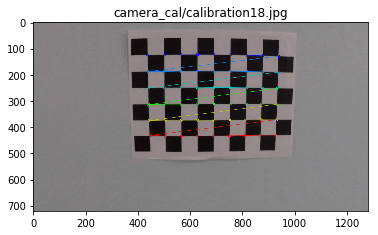

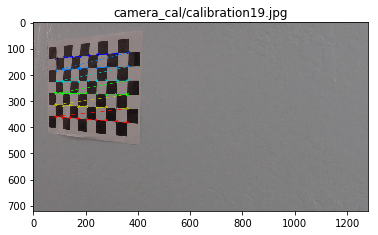

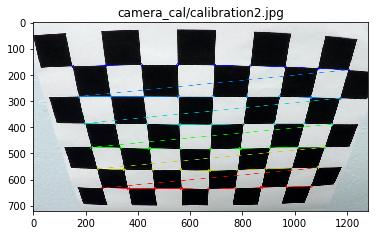

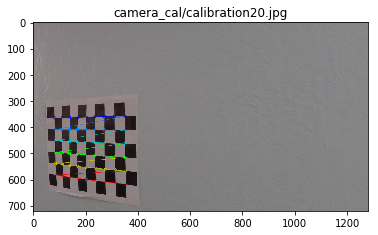

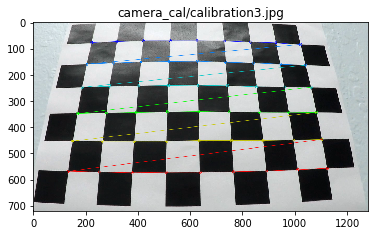

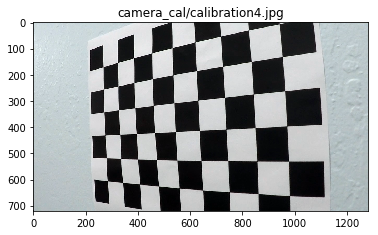

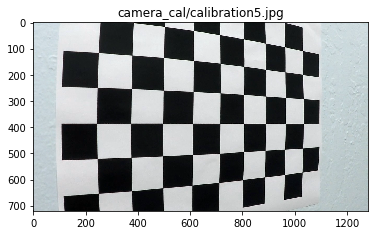

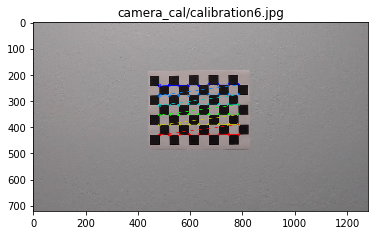

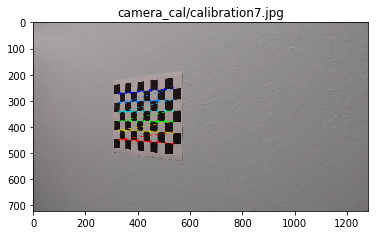

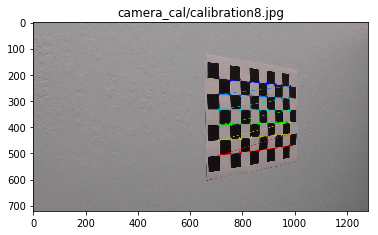

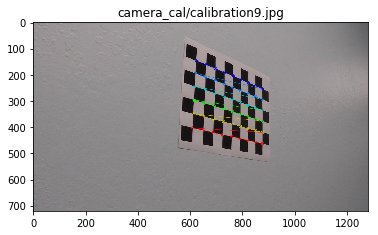

In [4]:
# Read in an image
images = glob.glob('camera_cal/calibration*.jpg')
images.sort()

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for image in images:
    img = cv2.imread(image)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    # If found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
    else:
        print(image, ": false")
        
    plt.figure()
    plt.title(image)
    plt.imshow(img)
    

### Result

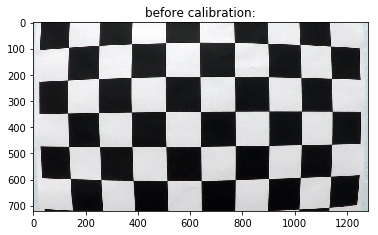

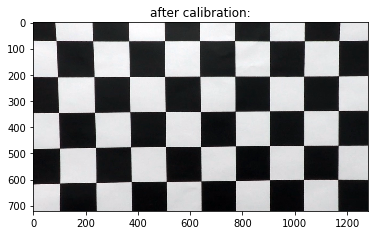

In [5]:
img = cv2.imread("camera_cal/calibration1.jpg")
plt.figure()
plt.title("before calibration:")
plt.imshow(img)
plt.savefig("output_images/before_calibration.jpg")

undistorted = cal_undistort(img, objpoints, imgpoints)
plt.figure()
plt.title("after calibration:")
plt.imshow(undistorted)
plt.savefig("output_images/after_calibration.jpg")


## Pipeline (test images)

### Binary image: combine color and gradient thresholding

In [6]:
def binary_image(img, s_thresh=(200, 255), sx_thresh=(70, 210)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary


### Perspective transform

In [7]:
def perspective_transform(img):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Hardcode the source and destination points
    src = np.float32(
        [[(img_size[0]/2) - 55, img_size[1]/2 + 100],
        [((img_size[0]/6)-10), img_size[1]],
        [(img_size[0]*5/6)+60, img_size[1]],
        [(img_size[0]/2+55), img_size[1]/2+100]])

    dst = np.float32(
        [[(img_size[0]/4), 0],
        [(img_size[0]/4), img_size[1]],
        [(img_size[0]*3/4), img_size[1]],
        [(img_size[0]*3/4), 0]])
    
    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    # Return the resulting image and matrix
    return warped, M, Minv 


### Identify lane line: implement sliding windows and fit a polynomial

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, show=0):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    if (len(leftx)>0) & (len(lefty)>0) & (len(rightx)>0) & (len(righty)>0):
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        left_fit = left_line.current_fit
        right_fit = right_line.current_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    if(show == 0):
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    left_line.detected = True
    right_line.detected = True

    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit


### Calculated lane curvature and vehicle position

In [9]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def cal_curvature(img, fit):  
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    y_eval = y[-1]
    
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    curverad = np.round(curverad, 2)
    return curverad

def cal_lane_curv(img, left_fit, right_fit):
    avg_fit = np.mean([left_fit, right_fit], axis = 0)
    left_curvature = cal_curvature(img, left_fit)
    right_curvature = cal_curvature(img, right_fit)
    radius_of_curvature = cal_curvature(img, avg_fit)
    return radius_of_curvature


def cal_offset(img, left_fit, right_fit):
    y_eval = img.shape[0] - 1;
    left_x = left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]
    right_x = right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2]
    car_center = (left_x + right_x)/2
    lane_center = img.shape[1] / 2
    offset = (car_center - lane_center) * xm_per_pix
    return offset
    

### Drawing

In [10]:
def draw_figure(undistorted, warped, left_fit, right_fit, Minv, radius_of_curvature, offset):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    cv2.putText(result,'Radius of Curvature: %.2fm' % radius_of_curvature, (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255) , 2)
    if offset < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(offset), text), (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return result


### Example

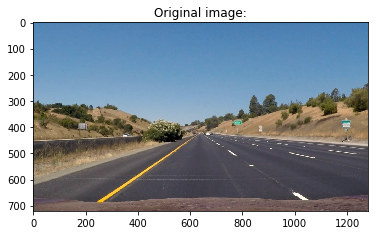

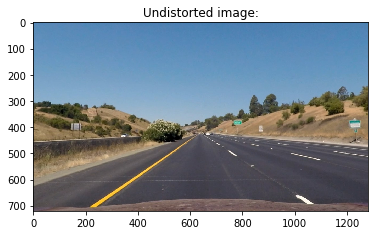

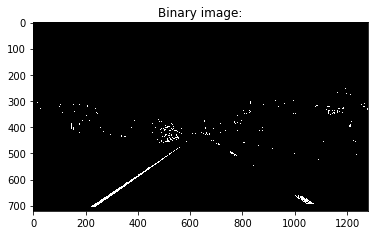

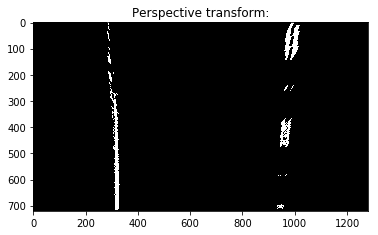

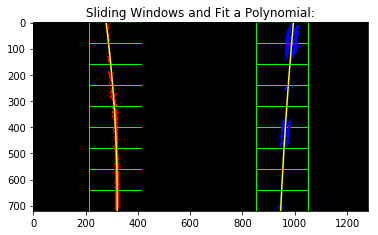

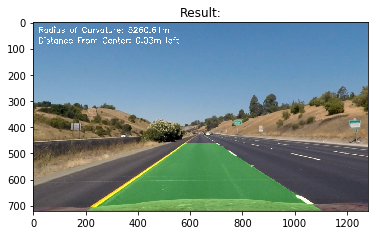

In [11]:
img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.title("Original image:")
plt.imshow(img)
plt.savefig("output_images/original.jpg")

undistorted = cal_undistort(img, objpoints, imgpoints)
plt.figure()
plt.title("Undistorted image:")
plt.imshow(undistorted)
plt.savefig("output_images/undistorted.jpg")

binary = binary_image(undistorted)
plt.figure()
plt.title("Binary image:")
plt.imshow(binary, cmap='gray')
plt.savefig("output_images/binary.jpg")

warped, M, Minv = perspective_transform(binary)
plt.figure()
plt.title("Perspective transform:")
plt.imshow(warped, cmap='gray')
plt.savefig("output_images/transform.jpg")

out_img, ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomial(warped)
plt.figure()
plt.title("Sliding Windows and Fit a Polynomial:")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)
plt.savefig("output_images/fit.jpg")

radius_of_curvature = cal_lane_curv(warped, left_fit, right_fit)
offset = cal_offset(warped, left_fit, right_fit)
result = draw_figure(undistorted, warped, left_fit, right_fit, Minv, radius_of_curvature, offset)
plt.figure()
plt.title("Result:")
plt.imshow(result)


### Image pipeline

In [12]:
def process_image(image):
    undistorted = cal_undistort(image, objpoints, imgpoints)
    binary = binary_image(undistorted)
    warped, M, Minv = perspective_transform(binary)
    out_img, ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomial(warped, 1)
    radius_of_curvature = cal_lane_curv(warped, left_fit, right_fit)
    offset = cal_offset(warped, left_fit, right_fit)
    result = draw_figure(undistorted, warped, left_fit, right_fit, Minv, radius_of_curvature, offset)
    return result


### Result

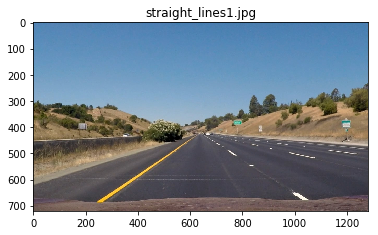

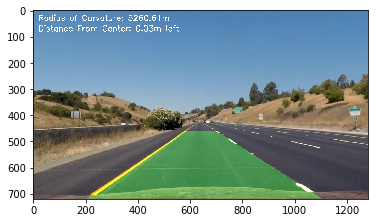

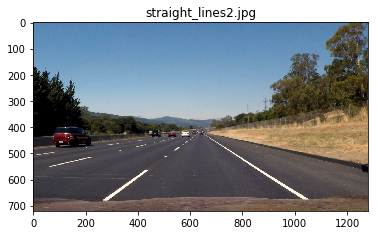

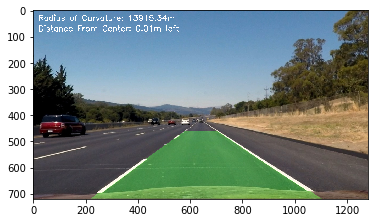

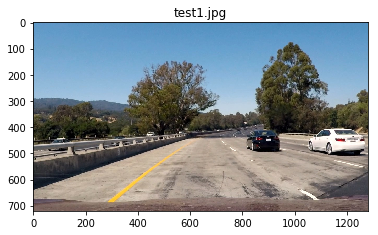

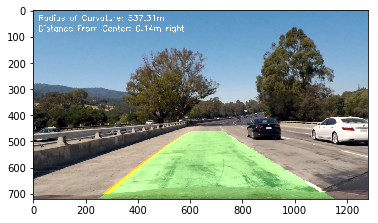

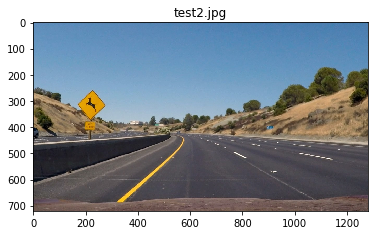

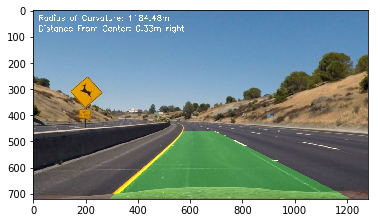

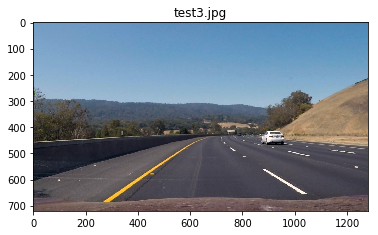

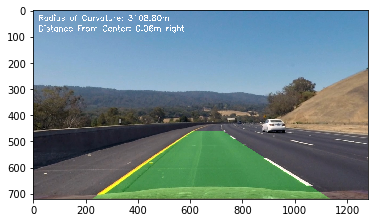

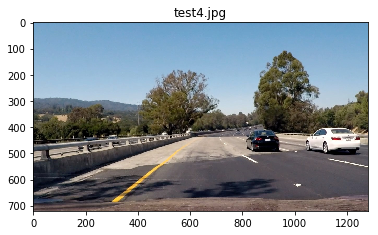

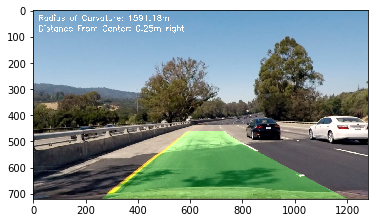

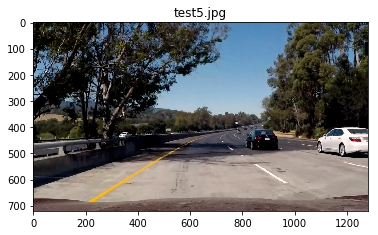

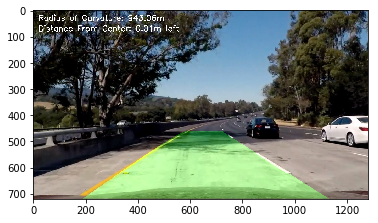

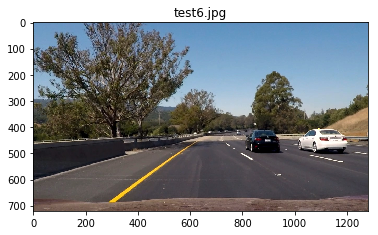

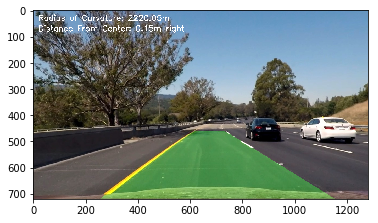

In [13]:
files = os.listdir("test_images/")
files.sort()

def show(path, filename):
    image = cv2.imread(path + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.title(filename)
    plt.imshow(image)
    plt.savefig("output_images/original_" + filename)

def process(input_path, output_path, filename):
    image = cv2.imread(input_path + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = process_image(image)
    plt.figure()
    plt.imshow(result)
    plt.savefig(output_path + filename)
    
for file in files:
    show("test_images/", file)
    process("test_images/", "output_images/", file)


## Pipeline (video)

### Look-Ahead Filter

In [14]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    if (len(leftx)>0) & (len(lefty)>0) & (len(rightx)>0) & (len(righty)>0):
        left_fit = np.polyfit(lefty,leftx, 2)
        right_fit = np.polyfit(righty,rightx, 2)
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
    else:
        left_fit = left_line.current_fit
        right_fit = right_line.current_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, show=0):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit   
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if(show == 0):
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##

    return result, ploty, left_fitx, right_fitx, left_fit, right_fit


### Video pipeline

In [15]:
left_line.detected = False
right_line.detected = False
left_line.current_fit = [np.array([False])]  
right_line.current_fit = [np.array([False])]  

def check_lane(left_fit,right_fit, h, w, radius_of_curvature, offset):
    # the slope difference between left_line slope and right_line 
    if np.abs((left_fit[0]*h+left_fit[1])-(right_fit[0]*h+right_fit[1])) > (w/h):
        return False
    # the distance between right_bottom and left_bottom
    if (right_fit[0]*h**2+right_fit[1]*h+right_fit[2])-(left_fit[0]*h**2+left_fit[1]*h+left_fit[2]) < (w/2):
        return False
    return True

def process_frame(image):
    undistorted = cal_undistort(image, objpoints, imgpoints)
    binary = binary_image(undistorted)
    warped, M, Minv = perspective_transform(binary)
    
    if (left_line.detected == False) | (right_line.detected == False): 
        out_img, ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomial(warped, 1)
    else:
        out_img, ploty, left_fitx, right_fitx, left_fit, right_fit = search_around_poly(warped, 1)
         
    radius_of_curvature = cal_lane_curv(warped, left_fit, right_fit)
    offset = cal_offset(warped, left_fit, right_fit)
    
    if (check_lane(left_fit,right_fit,warped.shape[0], warped.shape[1], radius_of_curvature, offset) == False):
        left_line.detected = False
        right_line.detected = False   
        
    result = draw_figure(undistorted, warped, left_fit, right_fit, Minv, radius_of_curvature, offset)
    return result


### Video example

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_frame)
%time video_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [11:14<00:00,  1.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 56s, sys: 2.91 s, total: 8min 59s
Wall time: 11min 17s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))


In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
video_clip = clip1.fl_image(process_frame)
%time video_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [04:18<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 3min 25s, sys: 4.82 s, total: 3min 29s
Wall time: 4min 21s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))
